# Problem Set 4, due October 23 at 11:59pm

### Before You Start

This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set to make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions (especially the sections on vectorized computation and computational efficiency).
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 4.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names).

In [78]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt  

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.tools import eval_measures

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.cross_validation import KFold

random_state=13579
np.random.seed(seed=random_state)

In [79]:
from sklearn.datasets import load_boston
bdata = load_boston()

---

## Part 1: Getting oriented


### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  Interpret your results.

                            OLS Regression Results                            
Dep. Variable:            MedianPrice   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Mon, 23 Oct 2017   Prob (F-statistic):           2.49e-74
Time:                        14:58:38   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

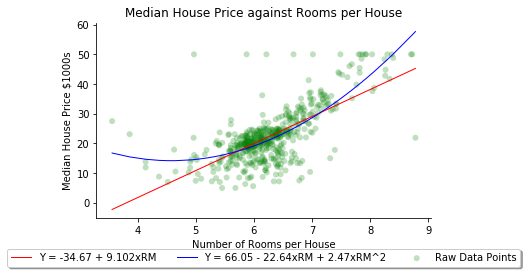

In [80]:
# uncomment the following if you want to see a lengthy description of the dataset
# print(bdata.keys())
# print(bdata.feature_names)
# print(bdata.data.shape)
# print(bdata.target.shape)
# print(bdata.DESCR)
bdataf = pd.DataFrame(data = bdata.data,columns=bdata.feature_names)
bdataf["MedianPrice"] = bdata.target
bdataf["RM_sq"] = bdataf["RM"]**2
OLSData = bdataf[["MedianPrice","RM","RM_sq"]]
OLSData = OLSData.sort_values(by="RM",ascending=True,kind='mergesort')


OLSData['ones'] = np.ones(len(bdataf))


#since we use statsmodels.formula.api a constant is automatically added to our data
#fit model on RM
model = smf.ols(formula="MedianPrice ~  RM", data=OLSData).fit()
print(model.summary())

#fit model on RM + RM^2
model2 = smf.ols(formula="MedianPrice ~  RM + RM_sq", data=OLSData).fit()
print(model2.summary())


Y_hat = model.predict(OLSData["RM"])
modelRMSE = eval_measures.rmse(Y_hat, OLSData["MedianPrice"])
Y_hat2 = model2.predict(OLSData[["RM","RM_sq"]])
model2RMSE = eval_measures.rmse(Y_hat2, OLSData["MedianPrice"])
OLSData["Y_hat"] = Y_hat
OLSData["Y_hat2"] = Y_hat2

OLSData = OLSData.sort_values(by="RM",ascending=True,kind='mergesort')
print('\n')
print('RMSE for OLS on RM only  :',modelRMSE)
print('RMSE for OLS on RM + RM^2:',model2RMSE)

# Plot outputs
fig = plt.figure()
ax = plt.gca()
ax.scatter(x = OLSData["RM"] ,y= OLSData["MedianPrice"], c='green', alpha=0.25, edgecolors='none', label='Raw Data Points')
ax.plot(OLSData["RM"], OLSData["Y_hat"], color='red', linewidth=1,label = 'Y = -34.67 + 9.102xRM')
ax.plot(OLSData["RM"], OLSData["Y_hat2"], color='blue', linewidth=1,label = 'Y = 66.05 - 22.64xRM + 2.47xRM^2')

plt_name = "Median House Price against Rooms per House"
plt.title(plt_name)
plt.xlabel('Number of Rooms per House')
plt.ylabel('Median House Price $1000s')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
          fancybox=True, shadow=True, ncol=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='x',which='both',top='off') # labels along the bottom edge are off
plt.tick_params(axis='y',which='both',right='off') # labels along the bottom edge are off

plt.show()


*Enter your observations here*

Based on the plot we can see that room number only or room numer and room number squared aren't the best models per se, the RMSE for the first model is USD 6,603 and for the second model is USD 6,174. We can also see the second order effect come through in the second model, the convexity from the polynomial term.

That said the polynomial model gives a lower error using RMSE, and based on that alone is better. The curvature also explains the difference between the intercepts on the y-axis.

Fitting a model Y = a + bRM yields a = -34.6 and b = 9.101. That is the intercept on the y-axis (Median House Price) is          -USD34.6k and the slope is USD9,101. The intercept implies that if a house has 0 rooms it will sell for a negative value, quite funny. Slope implies that for every 1 change in room the value of the house changes by USD9,101 (positively correlated)

Fitting a model Y = a + bRM + cRM^2 yields a = +66 and b = -22.64 and c = 2.47. Thus clearly a polynomial function. That is the intercept on the y-axis (Median House Price) is USD66k. The terms b and c govern the quick drop from the intercept as number of rooms go from 0 to 4, but then once we get to 6 rooms, the second order term comes through and starts offsetting the negative coefficient of the first order term, giving us the upwards lift.



### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 25-fold cross-validation to fit regression (a) above, i.e. the linear fit of housing price on number of rooms per house. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the 25 slope coefficients using a histogram, then draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you notice?

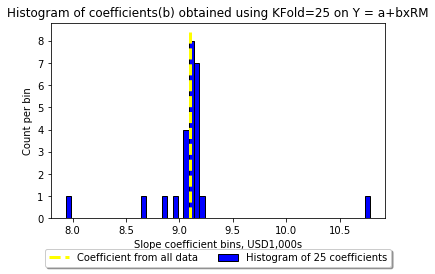

Average coefficient for Kfold 9.10024412261
Median coefficient for Kfold 9.10212760747
Std dev coefficient for Kfold 0.416977431512
Coefficient for model fit on all data 9.10210898118


In [81]:

n_folds = 25

kf = KFold(n=len(OLSData),n_folds= 25, random_state=random_state,shuffle=False)

regr = LinearRegression()
regr2 = LinearRegression()

X = OLSData[['ones','RM']].values
X2 = OLSData[['ones','RM','RM_sq']].values
Y = OLSData['MedianPrice'].values
Slope = []


for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    regr.fit(X_train,y_train)
    Slope.append(regr.coef_[1])
    
binwidth = 0.05
min_bin = (min(Slope))

max_bin = (max(Slope))

plt.hist(Slope, bins=np.arange(min_bin, max_bin + binwidth, binwidth),color = 'blue',edgecolor = "black",label = 'Histogram of 25 coefficients')
plt.color = "Green"
plt.xlabel('Slope coefficient bins, USD1,000s')
plt.ylabel('Count per bin')
ax = plt.gca()

plt_name = "Histogram of coefficients(b) obtained using KFold=25 on Y = a+bxRM"
plt.title(plt_name)

plt.tick_params(axis='x',which='both',top='off') # labels along the bottom edge are off
plt.tick_params(axis='y',which='both',right='off') # labels along the bottom edge are off

ylim98 = ax.get_ylim()
plt.plot((model.params['RM'], model.params['RM']), ylim98, 'k--',color = 'yellow',linewidth=3,label = 'Coefficient from all data')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
          fancybox=True, shadow=True, ncol=5)


plt.show()

print("Average coefficient for Kfold",np.mean(Slope))
print("Median coefficient for Kfold",np.median(Slope))
print("Std dev coefficient for Kfold",np.std(Slope))
print("Coefficient for model fit on all data",model.params['RM'])

*Enter your observations here*

Looking at the histogram the average coefficient seems to be around 9.1 and evaluating the median returns 9.0985, which is very close to 9.1. The std deviation is 0.27, showing the coefficients are quite close to 9.1.
The coefficient we found when fitting OLS to the model Y = a + bxRM for all data is 9.102, which is quite close to our average and median. I suspect there could be some impact as a result of our choice of random seed (13579), but I doubt this would be material.

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the two regression lines from 1.1 (or 1.2 if you prefer to do so). Show the linear regression line in red, and the linear+quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

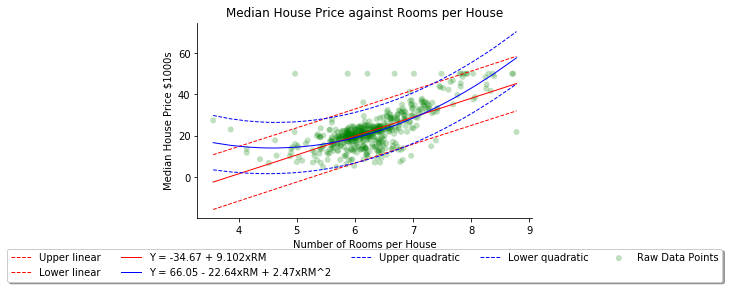

In [82]:
# Your code here
#from above
# Plot outputs

#confidence interval
stdev_m1, lower_m1, upper_m1 = wls_prediction_std(model)
stdev_m2, lower_m2, upper_m2 = wls_prediction_std(model2)

# OLSData['model2_upper'] = model2.conf_int(alpha=0.05)[1]["Intercept"] \
# + model2.conf_int(alpha=0.05)[1]["RM"]*OLSData["RM"]+model2.conf_int(alpha=0.05)[1]["RM_sq"]*OLSData["RM_sq"]
# OLSData['model2_lower'] = model2.conf_int(alpha=0.05)[0]["Intercept"] \
# +model2.conf_int(alpha=0.05)[0]["RM"]*OLSData["RM"]+model2.conf_int(alpha=0.05)[0]["RM_sq"]*OLSData["RM_sq"]
# # OLSData['model_lower'] = 
# OLSData['model_upper'] = model.conf_int(alpha=0.05)[1]["Intercept"]+model.conf_int(alpha=0.05)[1]["RM"]*OLSData["RM"]
# OLSData['model_lower'] = model.conf_int(alpha=0.05)[0]["Intercept"]+model.conf_int(alpha=0.05)[0]["RM"]*OLSData["RM"]

OLSData['model2_upper'] = upper_m2
OLSData['model2_lower'] = lower_m2

OLSData['model_upper'] =upper_m1
OLSData['model_lower'] = lower_m1



fig = plt.figure()
ax = plt.gca()
ax.scatter(x = OLSData["RM"] ,y= OLSData["MedianPrice"], c='green', alpha=0.25, edgecolors='none', label='Raw Data Points')
ax.plot(OLSData["RM"], OLSData["model_upper"],'k--', color='red', linewidth=1,label = 'Upper linear')
ax.plot(OLSData["RM"], OLSData["model_lower"],'k--', color='red', linewidth=1,label = 'Lower linear')
ax.plot(OLSData["RM"], OLSData["Y_hat"], color='red', linewidth=1,label = 'Y = -34.67 + 9.102xRM')



ax.plot(OLSData["RM"], OLSData["Y_hat2"], color='blue', linewidth=1,label = 'Y = 66.05 - 22.64xRM + 2.47xRM^2')


ax.plot(OLSData["RM"], OLSData["model2_upper"],'k--', color='blue', linewidth=1,label = 'Upper quadratic')
ax.plot(OLSData["RM"], OLSData["model2_lower"],'k--', color='blue', linewidth=1,label = 'Lower quadratic')

plt_name = "Median House Price against Rooms per House"
plt.title(plt_name)
plt.xlabel('Number of Rooms per House')
plt.ylabel('Median House Price $1000s')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
          fancybox=True, shadow=True, ncol=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='x',which='both',top='off') # labels along the bottom edge are off
plt.tick_params(axis='y',which='both',right='off') # labels along the bottom edge are off

plt.show()



## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (average rooms per house)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: Some people like to include a MaxIterations parameter in their gradient descent algorithm, to prevent divergence. *

### Interrupt regular programming for special announcement
#### This next block is a progress bar I found on github, just helps me track progress
https://gist.github.com/minrk/2211026

In [83]:

import sys, time
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        try:
            clear_output()
        except Exception:
            # terminal IPython has no clear_output
            pass
        print('\r', self),
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = int((len(self.prog_bar) / 2) - len(str(percent_done)))
        pct_string = '%d%%' % percent_done

        print(self.prog_bar[0:pct_place])
        self.prog_bar = self.prog_bar[0:pct_place] + (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

###EXAMPLE HOW TO USE
# p = ProgressBar(1000)
# for i in range(1001):
#     p.animate(i)
#     time.sleep(0.01)


### Regular Programming now continues... for biavariate OLS

In [84]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
Convergence: Float
    minimum change that would indicate convergence
log: 0 or 1 Int
    if log is 1 then we will output the steps
gradientExplosionCheck: 0 or 1
    perform testing to stop algo if we get exploding thetas
ConvergenceCheck: 0 or 1
    do we want to stop if we get convergence or run till max
    
Returns
-------
alpha: float
    intercept
    
beta: float
    co-efficient
"""

def bivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000, Convergence = 0.000001,
                  log = 0,gradientExplosionCheck=1,ConvergenceCheck=0):
    # initialize the parameters
    start_time = time.time()

    # your code here
    # we need to minimise the loss function which is given by L(a,b) = Sum over i ((Y - a-bx(i))^2)
    # so we calculate the gradient of L with respect to our parameters a and b, so partial derivatives wrt a and b
    #derivative wrt a is Sum over i -2*(Y-a-bx(i))
    #derivative wrt b is Sum over i -x(i)*2*(Y-a-bx(i))
    #if we do what Andrew Ng did we can assume x0 is 1 and a is theta_zero and b is theta_1, then we can simplify things
    #and use matrix notation to get to the right place
    #first initialize an array containing our thetas, where theta 0 is alpha and theta 1 is beta and so forth
    numObs = float(xvalues.shape[0])
    theta = np.ones(shape=(xvalues.shape[1],1))
    #theta_change = 10000*np.ones(shape=(xvalues.shape[1],1))
    loss = np.dot(xvalues,theta)-yvalues
    theta_change = np.dot(xvalues.transpose(),loss)/numObs
    Iterations = 0
    oldJ = 0.0
    while (Iterations <= MaxIterations):
        
        loss = np.dot(xvalues,theta)-yvalues
        newJ = np.sum(loss ** 2) / (2.0 * numObs)
        theta_change = np.dot(xvalues.transpose(),loss)/numObs
        
        #built some code to output if our solver is not working, typically because learning rate is wrong
        #exploding gradient
        if gradientExplosionCheck == 1:
            if Iterations >0:
                if newJ > oldJ:
                    print("Increasing J! Stopping gradient descent")
                    break
        #check for convergence   
        if ConvergenceCheck==1:
            if (np.abs(R*theta_change) < Convergence).all():
                print("Convergence reached")
                break
        
        #update theta
        theta = theta - R*theta_change
        Iterations +=1
        oldJ = newJ
        #some code to print if we want to debug
        if log ==1:
            print("Iteration :",Iterations)
            print("theta_change:",theta_change)
            print('theta       :',theta)
            print('loss        :',loss)
            print('J           :',J)
    print('Iterations:',Iterations)        
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return theta[0,0], theta[1,0]

# example function call
#reshape Y from(506,) to (506,1)
Yreshape = Y.reshape(Y.shape[0],1)
closed_form_theta = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),np.dot(X.transpose(),Yreshape) )
print('Closed form solution',(closed_form_theta[0,0],closed_form_theta[1,0]))
print('\n')
R = 0.01
MaxIterations = 1000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(bivariate_ols(X, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1))
print('\n')
R = 0.01
MaxIterations = 10000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(bivariate_ols(X, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1))
print('\n')
R = 0.01
MaxIterations = 100000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(bivariate_ols(X, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1))
print('\n')
R = 0.05
MaxIterations = 1000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(bivariate_ols(X, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1))
print('\n')
R = 0.005
MaxIterations = 100000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(bivariate_ols(X, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1))
print('\n')
R = 0.001
MaxIterations = 100000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(bivariate_ols(X, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1))

Closed form solution (-34.670620776439819, 9.1021089811804927)


Gradient descent R:0.01 MaxIterations:1000 Convergence:1e-06
Iterations: 1001
Time taken: 0.10 seconds
(-2.7058259884658269, 4.0770811890010741)


Gradient descent R:0.01 MaxIterations:10000 Convergence:1e-06
Iterations: 10001
Time taken: 0.85 seconds
(-23.839268818041077, 7.3993655417542037)


Gradient descent R:0.01 MaxIterations:100000 Convergence:1e-06
Convergence reached
Iterations: 69646
Time taken: 4.18 seconds
(-34.662303915301628, 9.1008015284456985)


Gradient descent R:0.05 MaxIterations:1000 Convergence:1e-06
Increasing J! Stopping gradient descent
Iterations: 1
Time taken: 0.00 seconds
(1.7624085968379446, 5.9910528016798423)


Gradient descent R:0.005 MaxIterations:100000 Convergence:1e-06
Iterations: 100001
Time taken: 5.94 seconds
(-34.582323735803122, 9.088228238754045)


Gradient descent R:0.001 MaxIterations:100000 Convergence:1e-06
Iterations: 100001
Time taken: 6.26 seconds
(-23.837391791331282, 7.399

*Enter your observations here*
The closed form solution shows alpha as -34.67062077 and beta as 9.1021089811804927
Playing around with various settings of the learning rate R and the max number of iterations reveals some interesting dynamics. If R is too large (R=0.5) in this problem then theta just explodes and does not converge, and won't ever converge. We then get nans. If R is too small (R=0.005) then we need a lot of steps > 100,000 before we get close to our optimal solution. R around 0.01 seems to work well. However, we need quite a large number of steps to get a reasonable answer.

My alpha and beta for R=0.01 and MaxIterations = 100,000 and Convergence = 1e-06 is alpha = -34.662303 and beta = 9.10080152 and then we reach convergence at step 69,646

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [85]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using CRIM and RM as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with 2-3 different values of R.

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [86]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
Convergence: Float
    minimum change that would indicate convergence
log: 0 or 1 Int
    if log is 1 then we will output the steps
gradientExplosionCheck: 0 or 1
    perform testing to stop algo if we get exploding thetas
ConvergenceCheck: 0 or 1
    do we want to stop if we get convergence or run till max
HotTheta: Array of thetas
    if we want to restart gradient descent if it timed out


Returns
-------
theta: float
    array of coefficients X0 is 1, so theta 0 is the intercept
RMSE : float
    array of RMSE
"""

def multivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000, Convergence = 0.000001,
                  log = 0,gradientExplosionCheck=1,ConvergenceCheck=0,HotTheta=None):
    # initialize the parameters
    start_time = time.time()

    # your code here
    # we need to minimise the loss function which is given by L(a,b) = Sum over i ((Y - a-bx(i))^2)
    # so we calculate the gradient of L with respect to our parameters a and b, so partial derivatives wrt a and b
    #derivative wrt a is Sum over i -2*(Y-a-bx(i))
    #derivative wrt b is Sum over i -x(i)*2*(Y-a-bx(i))
    #if we do what Andrew Ng did we can assume x0 is 1 and a is theta_zero and b is theta_1, then we can simplify things
    #and use matrix notation to get to the right place
    #first initialize an array containing our thetas, where theta 0 is alpha and theta 1 is beta and so forth
    numObs = float(xvalues.shape[0])
    theta = np.ones(shape=(xvalues.shape[1],1))
    #if we need to restart the gradient descent at some theta
    if str(HotTheta)!='None':
        theta = HotTheta

    #theta_change = 10000*np.ones(shape=(xvalues.shape[1],1))
    loss = np.dot(xvalues,theta)-yvalues
    theta_change = np.dot(xvalues.transpose(),loss)/numObs
    Iterations = 0
    oldJ = 0.0
    RMSE = []
    while (Iterations <= MaxIterations):
        #loss is the diff between predicted and true
        loss = np.dot(xvalues,theta)-yvalues
        sqrLoss = np.power(loss,2)
        #newJ is the derivative
        newJ = np.sum(sqrLoss) / (2.0 * numObs)
        
        
        theta_change = np.dot(xvalues.transpose(),loss)/numObs
        
        #built some code to output if our solver is not working, typically because learning rate is wrong
        #exploding gradient
        if gradientExplosionCheck == 1:
            if Iterations >0:
                if newJ > oldJ:
                    print("Increasing J! Stopping gradient descent")
                    break
        #check for convergence   
        if ConvergenceCheck==1:
            if (np.abs(R*theta_change) < Convergence).all():
                print("Convergence reached")
                break
        
        #update theta
        theta = theta - R*theta_change
        Iterations +=1
        oldJ = newJ
        #RMSE is the RMSE
        RMSE.append(np.power(np.sum(sqrLoss)/ numObs,0.5))
        #some code to print if we want to debug
        if log ==1:
            print("Iteration :",Iterations)
            print("theta_change:",theta_change)
            print('theta       :',theta)
            print('loss        :',loss)
            print('J           :',J)
    print('Iterations:',Iterations)        
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return theta, RMSE

X_new = standardize(bdataf[['RM','CRIM']].values)
#add columns of ones for the intercept
X_plusone = np.c_[ np.ones(X_new.shape[0]),X_new]


Y = bdataf['MedianPrice'].values
#reshape Y to make is (506,1) and not just (506,)
Yreshape = Y.reshape(Y.shape[0],1)

closed_form_theta = np.dot(np.linalg.inv(np.dot(X_plusone.transpose(),X_plusone)),np.dot(X_plusone.transpose(),Yreshape) )
print('Closed form solution',(closed_form_theta))
print('\n')
R = 0.01
MaxIterations = 1000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])
print('\n')
R = 0.01
MaxIterations = 10000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])
print('\n')
R = 0.05
MaxIterations = 1000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])
print('\n')
R = 0.1
MaxIterations = 1000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])
print('\n')
R = 1
MaxIterations = 1000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])
print('\n')
R = 10
MaxIterations = 1000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = 0.000001,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])

Closed form solution [[ 22.53280632]
 [  5.89441657]
 [ -2.24860926]]


Gradient descent R:0.01 MaxIterations:1000 Convergence:1e-06
Iterations: 1001
Time taken: 0.17 seconds
[[ 22.53188602]
 [  5.89407352]
 [ -2.24891475]]


Gradient descent R:0.01 MaxIterations:10000 Convergence:1e-06
Convergence reached
Iterations: 1222
Time taken: 0.20 seconds
[[ 22.53270648]
 [  5.89435787]
 [ -2.24866547]]


Gradient descent R:0.05 MaxIterations:1000 Convergence:1e-06
Convergence reached
Iterations: 271
Time taken: 0.04 seconds
[[ 22.53278655]
 [  5.89439931]
 [ -2.24862621]]


Gradient descent R:0.1 MaxIterations:1000 Convergence:1e-06
Convergence reached
Iterations: 139
Time taken: 0.02 seconds
[[ 22.53279693]
 [  5.89440622]
 [ -2.2486195 ]]


Gradient descent R:1 MaxIterations:1000 Convergence:1e-06
Convergence reached
Iterations: 11
Time taken: 0.01 seconds
[[ 22.53280632]
 [  5.89441676]
 [ -2.24860955]]


Gradient descent R:10 MaxIterations:1000 Convergence:1e-06
Increasing J! Stopping gra

*Enter your observations here*

The closed form solution is given by the following, with the first element being the intercept and the second and third being the coefficients of RM and CRIM respectively.
[[ 22.53280632]
 [  5.89441657]
 [ -2.24860926]]
 
 I the played with R=0.01 and found that at 1222 steps it converged on values close to the closed form. I then increased R to 0.05 and found it converged at 271 steps, with R at 0.1 it converged at 139 steps and with R at 1 it converged at 11 steps. At R = 10 it started blowing out the gradients.
 
 My solution for R = 1 which took 11 steps is as follows, and is pretty close to the closed form solution.
 [[ 22.53280632]
 [  5.89441676]
 [ -2.24860955]]

By using linear algebra matrix notation to do the calculation the algorithm seems some order of magnitudes faster than if I would have used for loops.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [87]:
# Your code here

X_notstd = bdataf[['RM','CRIM']].values
#add columns of ones for the intercept
X_notstd_plusone = np.c_[ np.ones(X_notstd.shape[0]),X_notstd]



closed_form_theta = np.dot(np.linalg.inv(np.dot(X_notstd_plusone.transpose(),X_notstd_plusone)),np.dot(X_notstd_plusone.transpose(),Yreshape) )
print('Closed form solution',(closed_form_theta))
print('\n')
R = 0.01
MaxIterations = 1000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_notstd_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])
print('\n')
R = 0.01
MaxIterations = 10000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_notstd_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])
print('\n')
R = 0.01
MaxIterations = 100000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_notstd_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])
print('\n')
R = 0.1
MaxIterations = 100000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_notstd_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])
print('\n')
R = 0.001
MaxIterations = 100000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_notstd_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])
print('\n')
R = 0.0001
MaxIterations = 100000
Convergence = 0.000001
print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
print(multivariate_ols(X_notstd_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = Convergence,gradientExplosionCheck = 1,
                   ConvergenceCheck=1)[0])

Closed form solution [[-29.30168135]
 [  8.3975317 ]
 [ -0.2618229 ]]


Gradient descent R:0.01 MaxIterations:1000 Convergence:1e-06
Iterations: 1001
Time taken: 0.18 seconds
[[-1.85402725]
 [ 4.13146462]
 [-0.35350487]]


Gradient descent R:0.01 MaxIterations:10000 Convergence:1e-06
Iterations: 10001
Time taken: 1.52 seconds
[[-19.28808162]
 [  6.84116233]
 [ -0.2952708 ]]


Gradient descent R:0.01 MaxIterations:100000 Convergence:1e-06
Convergence reached
Iterations: 72683
Time taken: 10.97 seconds
[[-29.29275532]
 [  8.39614437]
 [ -0.26185271]]


Gradient descent R:0.1 MaxIterations:100000 Convergence:1e-06
Increasing J! Stopping gradient descent
Iterations: 1
Time taken: 0.00 seconds
[[ 2.16544112]
 [ 8.8561449 ]
 [-5.09952726]]


Gradient descent R:0.001 MaxIterations:100000 Convergence:1e-06
Iterations: 100001
Time taken: 15.33 seconds
[[-19.28650617]
 [  6.84091747]
 [ -0.29527606]]


Gradient descent R:0.0001 MaxIterations:100000 Convergence:1e-06
Iterations: 100001
Time taken

*Enter your observations here*
The closed form solution is the same, whether we standardize or not...but!

Without standardization the gradient descent algorithm seems to get stuck in some local minima, and further more is running slower (i.e. needs more steps to hit anything). Maybe this could be because of the way I initialise my original theta values, but I highly doubt it. Standardization just seems to help get to a minimum quicker and gets us closer to the optimal solution.

One value seems close to the closed form
Gradient descent R:0.01 MaxIterations:100000 Convergence:1e-06

Convergence reached

Iterations: 72683

Time taken: 4.79 seconds

[[-29.29275532]
 [  8.39614437]
 [ -0.26185271]]

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Make sure to first standardize your features before proceeding.

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that in one of two ways. If you're feeling confident, use k-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be three, corresponding to the intercept and the two coefficients for CRIM and RM). Or if you want to do the quick and dirty version, randomly divide your data into a training set (66%) and testing set (34%) and use the training set to re-fit the regression from 2.3 above. 

*NOTE: * If using k-fold cross-validation, you will end up with a different set of parameters for each fold. In this case, use the parameters from the fold that has the highest test performance.

In [88]:
# Your code here
print('\n')

# print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
# print(multivariate_ols(X_plusone, Yreshape, R=R, MaxIterations=MaxIterations, Convergence = 0.000001,gradientExplosionCheck = 1,
#                    ConvergenceCheck=1))

R = 1
MaxIterations = 1000
Convergence = 0.000001
n_folds = 25

kf2 = KFold(n=len(X_plusone),n_folds= n_folds, random_state=random_state,shuffle=False)
kFold_thetas = []
kFold_J = []
i = 1

for train_index, test_index in kf2:
    print('\n')
    print("Fold number "+str(i)+" of "+str(kf2.n_folds))
    print("Gradient descent R:"+str(R)+" MaxIterations:"+str(MaxIterations)+" Convergence:"+str(Convergence))
    X_train2, X_test2 = X_plusone[train_index], X_plusone[test_index]
    y_train2, y_test2 = Yreshape[train_index], Yreshape[test_index]
    kfold_theta, RMSE = multivariate_ols(X_train2, y_train2, R=R, MaxIterations=MaxIterations, Convergence = Convergence,
                                   gradientExplosionCheck = 1,
                                   ConvergenceCheck=1)
    #calculate RMSE
    difference = np.dot(X_test2,kfold_theta)-y_test2
    sqrdiff = np.power(difference,2)
    J = np.power(np.sum(sqrdiff)/ len(X_test2),0.5)



    print("Fold number "+str(i)+" of "+str(kf2.n_folds)+" has a loss of "+str(J))

    print("Theta "+str(kfold_theta))
    
    kFold_thetas.append(kfold_theta)
    kFold_J.append(J)
    
    
    i+=1

print("\n")
minJpos = np.argmin(kFold_J)
minJ = kFold_J[minJpos]
minTheta = kFold_thetas[minJpos]
print("minimum J was given at fold "+str(minJpos+1)+" and the J was " +str(minJ))
print("theta parameters for fold with minimum J is "+str(minTheta))





Fold number 1 of 25
Gradient descent R:1 MaxIterations:1000 Convergence:1e-06
Convergence reached
Iterations: 12
Time taken: 0.01 seconds
Fold number 1 of 25 has a loss of 3.59461459114
Theta [[ 22.5302912 ]
 [  5.86406318]
 [ -2.25312805]]


Fold number 2 of 25
Gradient descent R:1 MaxIterations:1000 Convergence:1e-06
Convergence reached
Iterations: 12
Time taken: 0.01 seconds
Fold number 2 of 25 has a loss of 5.06821933419
Theta [[ 22.66206512]
 [  5.81816618]
 [ -2.29989241]]


Fold number 3 of 25
Gradient descent R:1 MaxIterations:1000 Convergence:1e-06
Convergence reached
Iterations: 12
Time taken: 0.01 seconds
Fold number 3 of 25 has a loss of 2.30447637972
Theta [[ 22.53291839]
 [  5.87210789]
 [ -2.25328462]]


Fold number 4 of 25
Gradient descent R:1 MaxIterations:1000 Convergence:1e-06
Convergence reached
Iterations: 12
Time taken: 0.01 seconds
Fold number 4 of 25 has a loss of 1.54228462036
Theta [[ 22.53826463]
 [  5.89664721]
 [ -2.25029128]]


Fold number 5 of 25
Grad

*Discuss your results here*

### Our Optimal solution from 2.3 was
Gradient descent R:1 MaxIterations:1000 Convergence:1e-06
Convergence reached
Iterations: 11
Time taken: 0.00 seconds
[[ 22.53280632]
 [  5.89441676]
 [ -2.24860955]]

### Using CV
Using the same R=1, MaxIterations=1000 and Convergence = 1e-06 we proceed to run kFold Cross-Validation 25 times. We find that using these parameters the 4th fold (start count at 1) gives us the bestperformance with J (aka RMSE) = 1.54228462036 and the estimated parameters are
 [[ 22.53826463]
 [  5.89664721]
 [ -2.25029128]], thus quite close to what we calculated before.
 
 
### Note that the results of the CV are sensitive to the order in which I've sorted my dataset

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the RMSE on your test cases, i.e. take the model parameters that you found above, predict the values for just the test instances, and compare the actual to the predicted values. If you did this the k-fold way above, this will be the average RMSE across the k test sets. If you did this the quick and dirty way above, this will just be the RMSE on your single test set.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?

In [89]:
# Your code here
print("OLS with Kfold")
minJpos = np.argmin(kFold_J)
minJ = kFold_J[minJpos]
minTheta = kFold_thetas[minJpos]
print("Minimum RMSE was given at fold "+str(minJpos+1)+" and the RMSE was " +str(minJ))
print("Average RMSE for 25fold Gradient CV " +str(np.mean(kFold_J)))
print("theta parameters for fold with minimum RMSE is "+str(minTheta))


OLS with Kfold
Minimum RMSE was given at fold 4 and the RMSE was 1.54228462036
Average RMSE for 25fold Gradient CV 5.52638905568
theta parameters for fold with minimum RMSE is [[ 22.53826463]
 [  5.89664721]
 [ -2.25029128]]


*Discuss your results here*

The details are below, but the OLS is giving a slightly lower RMSE of 5.52638905568 compared to the average of the best performing KNN using 25 folds on RM and CRIM (and testing K = 1 to 25) which is 5.879. My OLS is also much better implemented than KNN so it runs faster, especially after I figured out what learning rate to use. If my algorithm was slower, then I highly doubt that OLS would be faster than KNN when using gradient descent.

**OLS with 25-fold CV**
OLS with Kfold
Minimum RMSE was given at fold 4 and the RMSE was 1.54228462036
Average RMSE is 5.52638905568
theta parameters for fold with minimum RMSE is [[ 22.53826463]
 [  5.89664721]
 [ -2.25029128]]

**KNN 25-fold CV algorithm for RM and CRIM, minimum RMSE 5.879 highlighted**
CV Time taken: 2.189556360244751 seconds

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 1 is 7.2104

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 2 is 6.5011

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 3 is 6.3561

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 4 is 6.2313

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 5 is 6.1363

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 6 is 6.039

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 7 is 5.9924

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 8 is 5.9778

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 9 is 5.9616

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 10 is 5.9537

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 11 is 5.9591

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 12 is 5.9506

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 13 is 5.9538

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 14 is 5.9413

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 15 is 5.9437

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 16 is 5.9112

**Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 17 is 5.879**

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 18 is 5.8973

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 19 is 5.8881

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 20 is 5.9007

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 21 is 5.8985

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 22 is 5.9091

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 23 is 5.9019

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 24 is 5.9029

Average RMSE for 10 fold CV using features ['CRIM', 'RM'], L = 2 and k = 25 is 5.917



### Extra Credit 1: Logistic Regression

For extra credit, implement logistic regression using gradient descent. Create a new variable (EXPENSIVE) to indicate whether the median housing price is more than $40,000. Use your model  a logistic regression of EXPENSIVE on CHAS and RM. Report your results.

In [13]:
# Your code here



*Discuss your results here*

## 4 Regularization 

### 4.1 Get prepped

Step 1: Create new interaction variables between each possible pair of the F_s features. If you originally had *K* features, you should now have K+(K*(K+1))/2 features. Standardize all of your features.
# Formula here is wrong, combination formula would be n!/(k!(n-k)!) which is K*(K-1)/2

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

In [90]:
# Your code here

RegX = pd.DataFrame(data = bdata.data,columns=bdata.feature_names)
RegY = pd.DataFrame()
RegY["MedianPrice"] = bdata.target


FeatureList = RegX.columns.tolist()
FeatureNum = len(FeatureList)
numWeNeed = FeatureNum + (FeatureNum*(FeatureNum-1))/2
#generate feature list all combinations of 2 features (without replacement)

#small function to multiply 2 columns
def genInteraction(X,Y):
    return X*Y

import itertools
featuresToTrain = []
for i in [1,2]:
    test = itertools.combinations(FeatureList,i)
    for i in test:
        featuresToTrain.append(list(i))
        if len(featuresToTrain[-1])!=1:
            newColName = str(featuresToTrain[-1][0])+"x"+str(featuresToTrain[-1][1])
            RegX[newColName] = genInteraction(RegX[featuresToTrain[-1][0]],RegX[featuresToTrain[-1][1]])

featuresToTrain =RegX.columns.tolist()
print("Our generated list has " + str(len(featuresToTrain)) +" features")
print("We need K + (K*(K-1))/2)= "+str(numWeNeed))

#normalize all our data
RegX_normalized = standardize(RegX)


#copied from PS3
def splitData(inputData,inputTarget,trainingPercentage = 0.8):
    if len(inputData)!=len(inputTarget):
        return "data sets not equal in size",-1
    else:
        countofData = len(inputData)
        #create array of index values that we will use to shuffle our data
        indexOrder = np.random.permutation(countofData)
        
        #shuffle the dataframes according to indexOrder
        inputData= inputData.iloc[indexOrder]
        inputTarget= inputTarget.iloc[indexOrder]
        
        #now we just slice the data accordingly
        #note I'm separating training and testing dataframes
        trainingData = inputData[0:int(trainingPercentage*len(inputData))]
        testingData = inputData[len(trainingData):]
        trainingTarget = inputTarget[0:int(trainingPercentage*len(inputTarget))]
        testingTarget = inputTarget[len(trainingTarget):]
        return trainingData,testingData,trainingTarget,testingTarget
    
trainingData,testingData,trainingTarget,testingTarget = splitData(RegX_normalized,RegY,0.66)


Our generated list has 91 features
We need K + (K*(K-1))/2)= 91.0


### 4.2 Overfitting (sort of)
Now, using your version of multivariate regression from 2.3, let's overfit the training data. Using your training set, regress housing price on as many of those K+(K*(K-1))/2 features as you can.  If you get too greedy, it's possible this will take a long time to compute, so start with 5-10 features, and if you have the time, add more features.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [92]:
#add ones
ColumsToTest = ['ones']
X_train_overfit = np.ones(len(trainingData))
X_test_overfit = np.ones(len(testingData))

#set up Ys and reshape them
#training
Y_train_OverFit = trainingTarget.values
Y_train_OverFit = Y_train_OverFit.reshape(Y_train_OverFit.shape[0],1)

#testing
Y_test_OverFit = testingTarget.values
Y_test_OverFit = Y_test_OverFit.reshape(Y_test_OverFit.shape[0],1)

In [48]:
# Your code here



R = .01
MaxIterations = 100000000
Convergence = 0.000001
Theta_no_reg = []
TrainRMSE_no_reg = []
TestRMSE_no_reg = []

#run each combination, incremental number of features in model or just run them all combined at once
# Incremental_or_LARGE = "LARGE"
# Incremental_or_LARGE = "LARGE"

# if Incremental_or_LARGE == "LARGE":

#set up our training data
X_train_overfit = np.c_[X_train_overfit,trainingData.values]

#set up our testing data
X_test_overfit = np.c_[X_test_overfit,testingData.values]

#cheating a bit and using a hot start by passing unconverged theta vector back into loop
#have run 1000000 steps once
TrainTheta_large, RMSE_large = multivariate_ols(X_train_overfit, Y_train_OverFit, R=R, MaxIterations=MaxIterations,
                                    Convergence = Convergence,
                                    gradientExplosionCheck = 1,
                                    ConvergenceCheck=1)
Theta_no_reg.append(TrainTheta_large)
TrainRMSE_no_reg.append(RMSE[-1])
difference = np.dot(X_test_overfit,TrainTheta_large)-Y_test_OverFit
sqrdiff = np.power(difference,2)
J = np.power(np.sum(sqrdiff)/ len(X_test_overfit),0.5)
TestRMSE_no_reg.append(J)

print("Num ofFeatures:"+str(X_train_overfit.shape[1]-1)+'\n')
print("Training RMSE :"+str(TrainRMSE_no_reg[-1])+'\n')
print("Testing RMSE  :"+str(TestRMSE_no_reg[-1])+'\n')
print('\n')
# print(Theta_no_reg[-1])


Convergence reached
Iterations: 34626126
Time taken: 2870.02 seconds
Num ofFeatures:91

Training RMSE :9.4162594404

Testing RMSE  :10.1018583141



[[  2.19775160e+01]
 [ -6.29534353e+01]
 [  6.12857125e+00]
 [ -1.92680220e+01]
 [ -2.74466023e+01]
 [ -1.21843184e+01]
 [  1.46540942e+01]
 [  4.47427016e+01]
 [ -1.22827989e+01]
 [  1.93630502e+01]
 [ -6.39304908e-01]
 [  4.04856297e+00]
 [  1.88050728e+00]
 [  8.91588802e+00]
 [  1.00376824e+00]
 [  3.20598376e+01]
 [ -7.16564768e+00]
 [ -1.58590061e+01]
 [  2.12911604e+01]
 [ -6.85561656e+00]
 [ -1.97812561e+00]
 [ -3.06676667e+01]
 [  3.49018145e+00]
 [  5.30970061e+01]
 [ -1.16528592e+00]
 [  8.73307639e+00]
 [ -2.43899593e-01]
 [ -6.88903917e-01]
 [  1.83384256e+00]
 [ -1.88384636e+00]
 [ -8.15642318e-03]
 [  1.83586814e+00]
 [ -6.71374364e-01]
 [  1.83060063e+00]
 [ -6.08864454e-02]
 [ -6.79589424e+00]
 [ -2.05307991e+00]
 [ -2.69838040e+00]
 [  1.74335923e+01]
 [  1.64119525e+01]
 [ -7.37609767e-01]
 [ -6.72548070e-01]
 [ -8.00915

In [51]:


closed_form_theta = np.dot(np.linalg.inv(np.dot(X_train_overfit.transpose(),X_train_overfit)),np.dot(X_train_overfit.transpose(),Y_train_OverFit) )
difference = np.dot(X_test_overfit,closed_form_theta)-Y_test_OverFit
sqrdiff = np.power(difference,2)
J = np.power(np.sum(sqrdiff)/ len(X_test_overfit),0.5)
print('Closed test RMSE',(J))
print('Closed form solution',(closed_form_theta))
print('\n')

Closed test RMSE 9.96484825988
Closed form solution [[  2.19914507e+01]
 [ -1.03714216e+02]
 [  6.09247038e+00]
 [ -1.81836452e+01]
 [ -2.74530627e+01]
 [ -1.04316579e+01]
 [  1.47191054e+01]
 [  4.44363057e+01]
 [ -1.21660946e+01]
 [  1.74814869e+01]
 [ -3.71425184e-01]
 [  4.73954810e+00]
 [  1.47281959e+00]
 [  9.41521788e+00]
 [  9.92975126e-01]
 [  1.05537278e+01]
 [ -6.89741706e+00]
 [ -1.56884789e+01]
 [  2.12653857e+01]
 [ -6.78624208e+00]
 [ -1.94043396e+00]
 [ -8.47796353e+01]
 [  1.03952645e+02]
 [  6.87470884e+01]
 [ -1.15339098e+00]
 [  8.70845324e+00]
 [ -2.78447766e-01]
 [ -7.18564818e-01]
 [  1.44391778e+00]
 [ -1.88840161e+00]
 [  1.11599125e-03]
 [  1.74261093e+00]
 [ -7.05224491e-01]
 [  1.88389731e+00]
 [ -2.33009131e-02]
 [ -6.35735642e+00]
 [ -2.01561451e+00]
 [ -2.91521993e+00]
 [  1.66749459e+01]
 [  1.63319560e+01]
 [ -6.04333844e-01]
 [ -8.04466277e-01]
 [ -8.41519033e+00]
 [ -1.16917011e+00]
 [ -6.11787894e+00]
 [ -4.36016075e-01]
 [ -3.31263590e-02]
 [  3.77

In [61]:
print("Sum of theta differences closed form vs gradient descent      :"+str((TrainTheta_large - closed_form_theta).sum()))
print("Sum of abs theta differences  closed form vs gradient descent :"+str(np.abs((TrainTheta_large - closed_form_theta)).sum()))

Sum of theta differences closed form vs gradient descent      :-0.609589237102
Sum of abs theta differences  closed form vs gradient descent :256.38084234


*Discuss your results here*

### Run using 91 features

Convergence reached

Iterations: 34626126

Time taken: 2870.02 seconds (aka like 47 minutes)

Num ofFeatures:91

Training RMSE :9.4162594404

Testing RMSE  :10.1018583141


### Closed form
Closed test RMSE 9.96484825988

It seems very very easy to get stuck in local minima with this amount of features. Also even though it converged, the sum of absolute theta differences is 256 different when we compare gradient descent to closed form. The sum of differences is -0.60959


### 4.3 Ridge regularization
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model from 4.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

Go brag to your friends about how you just implemented ridge-regularized multivariate regression using gradient descent optimization, from scratch. If you still have friends.

In [20]:
# Your code here
"""
Function
--------
multivariate_ols_with_ridge
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression. Also uses ridge regularization

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
lambd: float
    the regularization parameter used to penalize excessive features
MaxIterations: Int
    maximum number of iterations
Convergence: Float
    minimum change that would indicate convergence
log: 0 or 1 Int
    if log is 1 then we will output the steps
gradientExplosionCheck: 0 or 1
    perform testing to stop algo if we get exploding thetas
ConvergenceCheck: 0 or 1
    do we want to stop if we get convergence or run till max

Returns
-------
theta: float
    array of coefficients X0 is 1, so theta 0 is the intercept
RMSE : float
    array of RMSE
"""

def multivariate_ols_with_ridge(xvalues, yvalues, R=0.01,lambd=0.01, MaxIterations=1000, Convergence = 0.000001,
                  log = 0,gradientExplosionCheck=1,ConvergenceCheck=0):
    # initialize the parameters
    start_time = time.time()

    # your code here
    # we need to minimise the loss function which is given by L(a,b) = Sum over i ((Y - a-bx(i))^2)
    # so we calculate the gradient of L with respect to our parameters a and b, so partial derivatives wrt a and b
    #derivative wrt a is Sum over i -2*(Y-a-bx(i))
    #derivative wrt b is Sum over i -x(i)*2*(Y-a-bx(i))
    #if we do what Andrew Ng did we can assume x0 is 1 and a is theta_zero and b is theta_1, then we can simplify things
    #and use matrix notation to get to the right place
    #first initialize an array containing our thetas, where theta 0 is alpha and theta 1 is beta and so forth
    numObs = float(xvalues.shape[0])
    theta = np.ones(shape=(xvalues.shape[1],1))

    #theta_change = 10000*np.ones(shape=(xvalues.shape[1],1))
    loss = np.dot(xvalues,theta)-yvalues
    theta_change = np.dot(xvalues.transpose(),loss)/numObs
    Iterations = 0
    oldJ = 0.0
    RMSE = []
    while (Iterations <= MaxIterations):
        #loss is the diff between predicted and true
        loss = np.dot(xvalues,theta)-yvalues
        sqrLoss = np.power(loss,2)
        
        #as per Daume we don't regularize the intercept, page 95
        theta_for_reg = theta.copy()
        theta_for_reg[0,0]=0.
        #add the regularization
        #our loss = 0.5*Sum(y_true-y_pred)^2 + 0.5*lambda||theta||2
        #whether we divide this whole thing by number of obs doesn't affect the mathematical validity, it just means
        #that our learning rate is some order of magnitude different
        
        theta_change = np.dot(xvalues.transpose(),loss)/numObs + np.dot(float(lambd/numObs),theta_for_reg)
        
        #newJ is the derivative
        #so we need gradient wrt to intercept (theta[0]) and other thetas[1...n]
        newJ = np.sum(sqrLoss) / (2.0 * numObs) + np.dot(float(0.5*lambd),np.sum(np.power(theta_for_reg,2)))
        
        #built some code to output if our solver is not working, typically because learning rate is wrong
        #exploding gradient
        if gradientExplosionCheck == 1:
            if Iterations >0:
                if newJ > oldJ:
                    print("Increasing J! Stopping gradient descent")
                    break
        #check for convergence   
        if ConvergenceCheck==1:
            if (np.abs(R*theta_change) < Convergence).all():
                print("Convergence reached")
                break
        
        #update theta
        theta = theta - R*theta_change
        Iterations +=1
        oldJ = newJ
        #RMSE is the RMSE
        RMSE.append(np.power(np.sum(sqrLoss)/ numObs,0.5))
        #some code to print if we want to debug
        if log ==1:
            print("Iteration :",Iterations)
            print("theta_change:",theta_change)
            print('theta       :',theta)
            print('loss        :',loss)
            print('J           :',J)
    print('Iterations:',Iterations)        
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return theta, RMSE



In [93]:
#Redo 4.2

#add ones
ColumsToTest = ['ones']
X_train_overfit = np.ones(len(trainingData))
X_test_overfit = np.ones(len(testingData))

#set up Ys and reshape them
#training
Y_train_OverFit = trainingTarget.values
Y_train_OverFit = Y_train_OverFit.reshape(Y_train_OverFit.shape[0],1)

#testing
Y_test_OverFit = testingTarget.values
Y_test_OverFit = Y_test_OverFit.reshape(Y_test_OverFit.shape[0],1)

R = .01
lambd = 0.01
list_lambda = [0.01,0.05,0.1,0.5,1.,5.,10.,50.,100.,500.]
MaxIterations = 10000000
Convergence = 0.00000001
Theta_with_reg = []
TrainRMSE = []
TestRMSE = []

#run all features at once
    
#set up our training data
X_train_overfit = np.c_[X_train_overfit,trainingData.values]

#set up our testing data
X_test_overfit = np.c_[X_test_overfit,testingData.values]
for lll in list_lambda:
    TrainTheta, RMSE = multivariate_ols_with_ridge(X_train_overfit, Y_train_OverFit,lambd=lll, R=R, MaxIterations=MaxIterations,
                                        Convergence = Convergence,
                                        gradientExplosionCheck = 1,
                                        ConvergenceCheck=1)
    Theta_with_reg.append(TrainTheta)
    TrainRMSE.append(RMSE[-1])
    difference = np.dot(X_test_overfit,TrainTheta)-Y_test_OverFit
    sqrdiff = np.power(difference,2)
    J = np.power(np.sum(sqrdiff)/ len(X_test_overfit),0.5)
    TestRMSE.append(J)

    print("Lambda        :"+str(lll)+'\n')
    print("Num ofFeatures:"+str(X_train_overfit.shape[1]-1)+'\n')
    print("Training RMSE :"+str(TrainRMSE[-1])+'\n')
    print("Testing RMSE  :"+str(TestRMSE[-1])+'\n')
    print('\n')


Increasing J! Stopping gradient descent
Iterations: 445803
Time taken: 116.30 seconds
Lambda        :0.01

Num ofFeatures:91

Training RMSE :2.33028700081

Testing RMSE  :4.85613957772



Increasing J! Stopping gradient descent
Iterations: 40629
Time taken: 9.64 seconds
Lambda        :0.05

Num ofFeatures:91

Training RMSE :2.62825382952

Testing RMSE  :4.11646457258



Increasing J! Stopping gradient descent
Iterations: 13987
Time taken: 3.28 seconds
Lambda        :0.1

Num ofFeatures:91

Training RMSE :2.88609851623

Testing RMSE  :4.48353168346



Increasing J! Stopping gradient descent
Iterations: 986
Time taken: 0.25 seconds
Lambda        :0.5

Num ofFeatures:91

Training RMSE :3.84337670604

Testing RMSE  :5.58946574622



Increasing J! Stopping gradient descent
Iterations: 469
Time taken: 0.15 seconds
Lambda        :1.0

Num ofFeatures:91

Training RMSE :4.10327996446

Testing RMSE  :5.97297672623



Increasing J! Stopping gradient descent
Iterations: 291
Time taken: 0.08 second

In [94]:
print("Closed form for Ridge regularization as per Daume")
#get identity matrix
ThetaIdentity = np.identity(X_train_overfit.shape[1], dtype=float)
#don't regularize the intercepts
ThetaIdentity[0,0] = 0.0

Theta_with_reg_cc = []
TrainRMSE_cc = []
TestRMSE_cc = []

list_lambda = [0.0, 0.01,0.05,0.1,0.5,1.,5.,10.,50.,100.,500.]
for ll in list_lambda:
    closed_form_theta_with_reg = np.dot(np.linalg.inv(np.dot(X_train_overfit.transpose(),X_train_overfit)+np.dot(ll,ThetaIdentity)),
                                        np.dot(X_train_overfit.transpose(),Y_train_OverFit) )
    differencerr = np.dot(X_test_overfit,closed_form_theta_with_reg)-Y_test_OverFit
    sqrdiffrr = np.power(differencerr,2)
    Jrr = np.power(np.sum(sqrdiffrr)/ len(X_test_overfit),0.5)
    TestRMSE_cc.append(Jrr)
    Theta_with_reg_cc.append(closed_form_theta_with_reg)
    print('Lambda '+str(ll))
    print('Closed test RMSE',(TestRMSE_cc[-1]))
#     print('Closed form solution',(Theta_with_reg_cc[-1]))
    print('\n')

Closed form for Ridge regularization as per Daume
Lambda 0.0
Closed test RMSE 9.96484825988


Lambda 0.01
Closed test RMSE 7.02061672988


Lambda 0.05
Closed test RMSE 5.01546501951


Lambda 0.1
Closed test RMSE 4.52169264078


Lambda 0.5
Closed test RMSE 4.16397194219


Lambda 1.0
Closed test RMSE 4.27095204743


Lambda 5.0
Closed test RMSE 4.78324583201


Lambda 10.0
Closed test RMSE 4.99999259146


Lambda 50.0
Closed test RMSE 5.3481249652


Lambda 100.0
Closed test RMSE 5.46749978273


Lambda 500.0
Closed test RMSE 6.01918795967




*Discuss your results here*

On a first run I'm seenig some interesting results in that ridge regularization stops my gradient descent much sooner than without regularization, however, in all scenarios it stopped it because my loss function started increasing. Comparing the closed forridge regression to the gradient descent ridge regression, purely on RMSE for the test set, seems I have to tweak my parameters (R, and convergence) in order to better fine tune the model. 

### Extra Credit 2: Cross-validate lambda

Use k-fold cross-validation to select the optimal value of lambda. Report the average RMSE across all training sets, and the average RMSE across all testing sets. How do these numbers compare to each other, to the RMSE from your previous efforts?  Finally, create a scatter plot that shows RMSE as a function of lambda.

In [22]:
# Your code here

*Discuss your results here*

### (Showoff) Extra Credit 3: Lambda and coefficients

If you're feeling extra-special, create a parameter plot that shows how the different coefficient estimates change as a function of lambda. To make this graph intelligible, only include the *K* original F_s features in this plot

In [23]:
# Your code here

*Discuss your results here*